In [60]:
from __future__ import print_function, division
#virtualenv -p python3 venv

In [61]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import cPickle as pk
import pandas as pd
import numpy as np
from IPython.display import clear_output

In [62]:
import os
import sys
base_module_path = os.path.abspath(os.path.join('..'))
if base_module_path not in sys.path:
    sys.path.append(base_module_path)
import cervix as c

In [63]:
ls ../data/train/

Type_1/ Type_2/ Type_3/


In [64]:
df = c.data.make_base_df()
df = c.processing.transform_save_imgs(df, c.processing.resize_n, n=299);

In [65]:
train, validate, test = c.data.split_df(df); 

In [66]:
print(train.shape)
train.head()

(888, 5)


,path,Type,filetype,num_id,processed_path
137,../data/train/Type_1/441.jpg,1,jpg,441,../data/processed/resize_299/train/441.jpg
130,../data/train/Type_1/396.jpg,1,jpg,396,../data/processed/resize_299/train/396.jpg
1032,../data/train/Type_3/1003.jpg,3,jpg,1003,../data/processed/resize_299/train/1003.jpg
177,../data/train/Type_1/623.jpg,1,jpg,623,../data/processed/resize_299/train/623.jpg
1303,../data/train/Type_3/480.jpg,3,jpg,480,../data/processed/resize_299/train/480.jpg


In [8]:
print(validate.shape)
validate.head()

(296, 5)


,path,Type,filetype,num_id,processed_path
1126,../data/train/Type_3/1300.jpg,3,jpg,1300,../data/processed/resize_299/train/1300.jpg
1446,../data/train/Type_3/897.jpg,3,jpg,897,../data/processed/resize_299/train/897.jpg
588,../data/train/Type_2/225.jpg,2,jpg,225,../data/processed/resize_299/train/225.jpg
907,../data/train/Type_2/785.jpg,2,jpg,785,../data/processed/resize_299/train/785.jpg
674,../data/train/Type_2/381.jpg,2,jpg,381,../data/processed/resize_299/train/381.jpg


In [9]:
print(test.shape)
test.head()

(297, 5)


,path,Type,filetype,num_id,processed_path
1067,../data/train/Type_3/1107.jpg,3,jpg,1107,../data/processed/resize_299/train/1107.jpg
1305,../data/train/Type_3/49.jpg,3,jpg,49,../data/processed/resize_299/train/49.jpg
328,../data/train/Type_2/1138.jpg,2,jpg,1138,../data/processed/resize_299/train/1138.jpg
704,../data/train/Type_2/428.jpg,2,jpg,428,../data/processed/resize_299/train/428.jpg
191,../data/train/Type_1/7.jpg,1,jpg,7,../data/processed/resize_299/train/7.jpg


# Model creation

In [10]:
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras import backend as K

# create the base pre-trained model
base_model = InceptionV3(weights='imagenet', include_top=False)

# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(1024, activation='relu')(x)
# and a logistic layer -- let's say we have 200 classes
    # we have three classes so usung 3 on dense predictions
predictions = Dense(3, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

# we chose to train the top 2 inception blocks, i.e. we will freeze
# the first 172 layers and unfreeze the rest:
for layer in model.layers[:172]:
    layer.trainable = False
for layer in model.layers[172:]:
    layer.trainable = True

In [11]:
# compile the model (should be done *after* setting layers to non-trainable)
# TODO: loss function should be log loss. 'categorical_crossentropy' / c.submission.keras_log_loss
from keras.optimizers import SGD
model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy')
#model.compile(optimizer='rmsprop', loss='categorical_crossentropy')

In [12]:
# let's visualize layer names and layer indices to see how many layers
# we should freeze:
for i, layer in enumerate(base_model.layers):
    print(i, layer.name, layer.trainable)

0 input_1 False
1 conv2d_1 False
2 batch_normalization_1 False
3 activation_1 False
4 conv2d_2 False
5 batch_normalization_2 False
6 activation_2 False
7 conv2d_3 False
8 batch_normalization_3 False
9 activation_3 False
10 max_pooling2d_1 False
11 conv2d_4 False
12 batch_normalization_4 False
13 activation_4 False
14 conv2d_5 False
15 batch_normalization_5 False
16 activation_5 False
17 max_pooling2d_2 False
18 conv2d_9 False
19 batch_normalization_9 False
20 activation_9 False
21 conv2d_7 False
22 conv2d_10 False
23 batch_normalization_7 False
24 batch_normalization_10 False
25 activation_7 False
26 activation_10 False
27 average_pooling2d_1 False
28 conv2d_6 False
29 conv2d_8 False
30 conv2d_11 False
31 conv2d_12 False
32 batch_normalization_6 False
33 batch_normalization_8 False
34 batch_normalization_11 False
35 batch_normalization_12 False
36 activation_6 False
37 activation_8 False
38 activation_11 False
39 activation_12 False
40 mixed0 False
41 conv2d_16 False
42 batch_normaliza

In [43]:
# train the model on the new data for a few epochs
batch_size = 20
model_history = model.fit_generator(c.processing.df_to_keras_generator(train, batch_size, grayscale=False), 
                    steps_per_epoch=5,
                    epochs=9)


Epoch 1/9
5/5 [==============================] - 41s - loss: 0.9460    
Epoch 2/9
5/5 [==============================] - 39s - loss: 0.8697    
Epoch 3/9
5/5 [==============================] - 41s - loss: 0.9231    
Epoch 4/9
5/5 [==============================] - 41s - loss: 0.8939    
Epoch 5/9
5/5 [==============================] - 40s - loss: 0.9360    
Epoch 6/9
5/5 [==============================] - 39s - loss: 0.9129    
Epoch 7/9
5/5 [==============================] - 39s - loss: 0.9018    
Epoch 8/9
5/5 [==============================] - 41s - loss: 0.9416    
Epoch 9/9
5/5 [==============================] - 41s - loss: 0.8325    


In [46]:
print(model_history.history.keys())

['loss']


KeyError: 'val_loss'

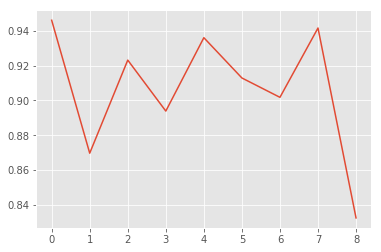

In [68]:
c.analysis.plot_log_errors(model_history)

In [ ]:
import h5py
f = h5py.File("mytestfile.hdf5", "w")

In [45]:
model.save('../data/model/v3_172_SGD_v1.h5')

In [26]:
batch_size_t = 1
model.evaluate_generator(c.processing.df_to_keras_generator(test, batch_size_t, grayscale=False)
                    ,len(test))

1.0170193722954504

In [21]:
batch_size_t = 1
predictions = model.predict_generator(c.processing.df_to_keras_generator(test, batch_size_t, grayscale=False)
                    ,len(test))
predictions

array([[ 0.16292104,  0.56425631,  0.27282271],
       [ 0.21223101,  0.41155878,  0.3762103 ],
       [ 0.23847002,  0.41175786,  0.34977207],
       [ 0.19286022,  0.47371903,  0.33342075],
       [ 0.24297421,  0.41416675,  0.34285903],
       [ 0.18828662,  0.4481324 ,  0.36358109],
       [ 0.18523452,  0.53188217,  0.28288335],
       [ 0.1542989 ,  0.56479722,  0.28090388],
       [ 0.198217  ,  0.42493504,  0.37684795],
       [ 0.1796591 ,  0.52864051,  0.29170042],
       [ 0.22449704,  0.30443898,  0.47106394],
       [ 0.17745136,  0.37727398,  0.44527468],
       [ 0.26859194,  0.41642544,  0.31498262],
       [ 0.12772673,  0.53523833,  0.33703491],
       [ 0.29650331,  0.27986833,  0.42362833],
       [ 0.1948674 ,  0.44079903,  0.3643336 ],
       [ 0.12845965,  0.64146698,  0.23007333],
       [ 0.22232543,  0.33138764,  0.44628689],
       [ 0.21642274,  0.53464264,  0.24893469],
       [ 0.11659321,  0.47471526,  0.40869153],
       [ 0.1516975 ,  0.38669869,  0.461

In [22]:
test_p = c.processing.append_probabilities(test, predictions, ['1','2','3']); test_p.head()

,path,Type,filetype,num_id,processed_path,Type_1,Type_2,Type_3
1067,../data/train/Type_3/1107.jpg,3,jpg,1107,../data/processed/resize_299/train/1107.jpg,0.162921,0.564256,0.272823
1305,../data/train/Type_3/49.jpg,3,jpg,49,../data/processed/resize_299/train/49.jpg,0.212231,0.411559,0.376210
328,../data/train/Type_2/1138.jpg,2,jpg,1138,../data/processed/resize_299/train/1138.jpg,0.238470,0.411758,0.349772
704,../data/train/Type_2/428.jpg,2,jpg,428,../data/processed/resize_299/train/428.jpg,0.192860,0.473719,0.333421
191,../data/train/Type_1/7.jpg,1,jpg,7,../data/processed/resize_299/train/7.jpg,0.242974,0.414167,0.342859


In [24]:
test_p.Type.value_counts()

2    156
3     93
1     48
Name: Type, dtype: int64

In [23]:
predictions.sum(0)

array([  59.54647446,  145.46858215,   91.98485565], dtype=float32)

In [27]:
score, ldf = c.submission.compute_losses(test_p)

Use: `df.sort_values('log_l', ascending=False)` to order by log_l


In [36]:
score

1.0430218929010968

In [42]:
ldf.sort_values('Type_2', ascending=False)

,path,Type,filetype,num_id,processed_path,Type_1,Type_2,Type_3,log_l
930,../data/train/Type_2/830.jpg,2,jpg,830,../data/processed/resize_299/train/830.jpg,0.134170,0.713057,0.152773,0.338194
947,../data/train/Type_2/857.jpg,2,jpg,857,../data/processed/resize_299/train/857.jpg,0.099218,0.710990,0.189792,0.341096
76,../data/train/Type_1/1422.jpg,1,jpg,1422,../data/processed/resize_299/train/1422.jpg,0.108316,0.700633,0.191051,2.222701
796,../data/train/Type_2/577.jpg,2,jpg,577,../data/processed/resize_299/train/577.jpg,0.105236,0.694083,0.200681,0.365164
419,../data/train/Type_2/1269.jpg,2,jpg,1269,../data/processed/resize_299/train/1269.jpg,0.081964,0.693209,0.224826,0.366424
1026,../data/train/Type_2/990.jpg,2,jpg,990,../data/processed/resize_299/train/990.jpg,0.112619,0.693208,0.194173,0.366426
1250,../data/train/Type_3/318.jpg,3,jpg,318,../data/processed/resize_299/train/318.jpg,0.073663,0.690915,0.235422,1.446375
410,../data/train/Type_2/1258.jpg,2,jpg,1258,../data/processed/resize_299/train/1258.jpg,0.149041,0.688211,0.162748,0.373660
163,../data/train/Type_1/560.jpg,1,jpg,560,../data/processed/resize_299/train/560.jpg,0.129988,0.684178,0.185835,2.040315
452,../data/train/Type_2/1325.jpg,2,jpg,1325,../data/processed/resize_299/train/1325.jpg,0.146918,0.674742,0.178339,0.393424


../data/train/Type_1/846.jpg
(3264, 2448, 3)


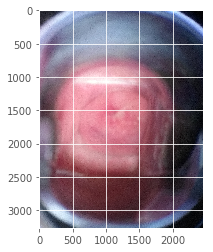

In [29]:
c.data.check_image(ldf.sort_values('log_l', ascending=False).path.iloc[0])

../data/processed/resize_299/train/846.jpg
(299, 299, 3)


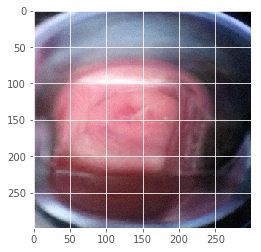

In [31]:
c.data.check_image(ldf.sort_values('log_l', ascending=False).processed_path.iloc[0])

../data/train/Type_1/57.jpg
(4128, 3096, 3)


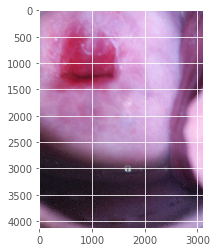

In [32]:
c.data.check_image(ldf.sort_values('log_l', ascending=False).path.iloc[1])

../data/processed/resize_299/train/57.jpg
(299, 299, 3)


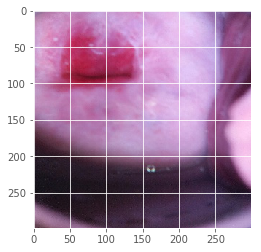

In [33]:
c.data.check_image(ldf.sort_values('log_l', ascending=False).processed_path.iloc[1])

../data/train/Type_1/551.jpg
(4128, 3096, 3)


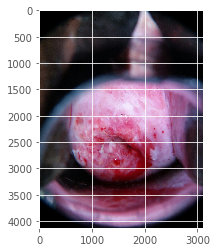

In [34]:
c.data.check_image(ldf.sort_values('log_l', ascending=False).path.iloc[3])

../data/processed/resize_299/train/551.jpg
(299, 299, 3)


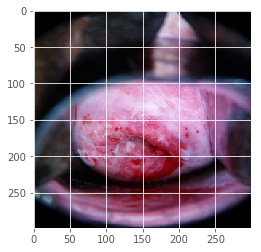

In [35]:
c.data.check_image(ldf.sort_values('log_l', ascending=False).processed_path.iloc[3])

../data/processed/resize_299/train/237.jpg
(299, 299, 3)


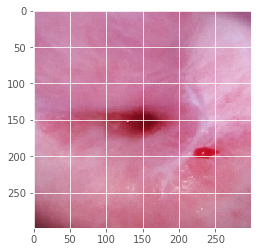

In [53]:
c.data.check_image(ldf.sort_values('log_l', ascending=False).processed_path.iloc[4])

In [69]:
import platform